In [1]:
import torch
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np
import time
import onnxruntime as ort
import os
from torchinfo import summary as torch_summary
from pathlib import Path
from sklearn.metrics import r2_score
from torch.utils.data import DataLoader
from dataset_impl import prepare_dataset
from train_rl_pipeline import DynamicsModel, Actor, Critic, make_loaders  # adjust imports to your module layout
import os
import pandas as pd
from pprint import pprint
from scipy.signal import savgol_filter
import joblib
import netron

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
sns.set_style("whitegrid")

In [2]:
def plot_comprehensive_analysis(results, metrics, save_dir):
    """Generate comprehensive analysis plots"""
    
    fig = plt.figure(figsize=(20, 16))
    
    # Action comparison plots
    plt.subplot(4, 4, 1)
    plt.scatter(results['gt_actions']['throttle'], results['policy_actions']['throttle'], alpha=0.6)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('Ground Truth Throttle')
    plt.ylabel('Policy Throttle')
    plt.title(f"Throttle: R²={metrics['throttle_r2']:.3f}")
    
    plt.subplot(4, 4, 2)
    plt.scatter(results['gt_actions']['steering'], results['policy_actions']['steering'], alpha=0.6)
    plt.plot([-1, 1], [-1, 1], 'r--')
    plt.xlabel('Ground Truth Steering')
    plt.ylabel('Policy Steering')
    plt.title(f"Steering: R²={metrics['steering_r2']:.3f}")
    
    # State prediction plots
    plt.subplot(4, 4, 3)
    plt.scatter(results['gt_states']['degradation'], results['predicted_states']['degradation'], alpha=0.6)
    plt.xlabel('GT Degradation')
    plt.ylabel('Predicted Degradation')
    plt.title(f"Degradation: R²={metrics['degradation_r2']:.3f}")
    
    plt.subplot(4, 4, 4)
    plt.scatter(results['gt_states']['speed'], results['predicted_states']['speed'], alpha=0.6)
    plt.xlabel('GT Speed')
    plt.ylabel('Predicted Speed')
    plt.title(f"Speed: R²={metrics['speed_r2']:.3f}")
    
    # Time series plots
    plt.subplot(4, 4, 5)
    window_size = min(1000, len(results['rewards']))
    plt.plot(results['rewards'][:window_size])
    plt.xlabel('Timestep')
    plt.ylabel('Reward')
    plt.title(f"Rewards (μ={metrics['mean_reward']:.3f})")
    
    plt.subplot(4, 4, 6)
    plt.plot(results['q_values'][:window_size])
    plt.xlabel('Timestep')
    plt.ylabel('Q-Value')
    plt.title(f"Q-Values (μ={metrics['mean_q_value']:.3f})")
    
    # Distribution plots
    plt.subplot(4, 4, 7)
    plt.hist(results['policy_actions']['throttle'], bins=50, alpha=0.7, label='Policy')
    plt.hist(results['gt_actions']['throttle'], bins=50, alpha=0.7, label='GT')
    plt.xlabel('Throttle Action')
    plt.ylabel('Frequency')
    plt.legend()
    plt.title('Throttle Distribution')
    
    plt.subplot(4, 4, 8)
    plt.hist(results['policy_entropy'], bins=50, alpha=0.7)
    plt.xlabel('Policy Entropy')
    plt.ylabel('Frequency')
    plt.title(f'Policy Entropy (μ={metrics["mean_entropy"]:.3f})')
    
    # Performance summary table
    plt.subplot(4, 4, (9, 12))
    plt.axis('off')
    summary_text = f"""
    PERFORMANCE SUMMARY
    
    Action Prediction:
    • Throttle MAE: {metrics['throttle_mae']:.4f}
    • Steering MAE: {metrics['steering_mae']:.4f}
    • Throttle R²: {metrics['throttle_r2']:.3f}
    • Steering R²: {metrics['steering_r2']:.3f}
    
    State Prediction:
    • Degradation R²: {metrics['degradation_r2']:.3f}
    • Speed R²: {metrics['speed_r2']:.3f}
    • Range R²: {metrics['range_r2']:.3f}
    
    Policy Performance:
    • Mean Episode Return: {metrics['episode_return']:.3f}
    • Mean Reward: {metrics['mean_reward']:.3f} ± {metrics['std_reward']:.3f}
    • Mean Q-Value: {metrics['mean_q_value']:.3f}
    • Policy Entropy: {metrics['mean_entropy']:.3f}
    """
    plt.text(0.1, 0.9, summary_text, fontsize=10, verticalalignment='top', 
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
    
    plt.tight_layout()
    plt.savefig(save_dir / "sac_inference_analysis.png", dpi=300, bbox_inches='tight')
    plt.show()

In [3]:
def calculate_performance_metrics(results):
    """Calculate comprehensive performance metrics"""
    metrics = {}
    
    # Action prediction metrics
    for action_type in ['throttle', 'steering']:
        gt = np.array(results['gt_actions'][action_type])
        pred = np.array(results['policy_actions'][action_type])
        
        metrics[f'{action_type}_mse'] = np.mean((gt - pred) ** 2)
        metrics[f'{action_type}_mae'] = np.mean(np.abs(gt - pred))
        metrics[f'{action_type}_r2'] = 1 - np.var(gt - pred) / np.var(gt)
        metrics[f'{action_type}_correlation'] = np.corrcoef(gt, pred)[0, 1]
    
    # State prediction metrics
    for state_type in ['degradation', 'speed', 'range', 'soc']:
        gt = np.array(results['gt_states'][state_type])
        pred = np.array(results['predicted_states'][state_type])
        
        metrics[f'{state_type}_mse'] = np.mean((gt - pred) ** 2)
        metrics[f'{state_type}_mae'] = np.mean(np.abs(gt - pred))
        metrics[f'{state_type}_r2'] = 1 - np.var(gt - pred) / np.var(gt)
    
    # Policy metrics
    metrics['mean_reward'] = np.mean(results['rewards'])
    metrics['std_reward'] = np.std(results['rewards'])
    metrics['mean_q_value'] = np.mean(results['q_values'])
    metrics['mean_entropy'] = np.mean(results['policy_entropy'])
    metrics['episode_return'] = np.mean(results['episode_returns'])
    
    return metrics

In [4]:
def print_analysis_summary(metrics):
    """Print comprehensive analysis summary"""
    print("\n" + "="*60)
    print("SAC INFERENCE ANALYSIS SUMMARY")
    print("="*60)
    
    print(f"\n📊 ACTION PREDICTION PERFORMANCE:")
    print(f"   Throttle - MAE: {metrics['throttle_mae']:.4f}, R²: {metrics['throttle_r2']:.3f}")
    print(f"   Steering - MAE: {metrics['steering_mae']:.4f}, R²: {metrics['steering_r2']:.3f}")
    
    print(f"\n🔋 STATE PREDICTION PERFORMANCE:")
    print(f"   Degradation R²: {metrics['degradation_r2']:.3f}")
    print(f"   Speed R²: {metrics['speed_r2']:.3f}")
    print(f"   Range R²: {metrics['range_r2']:.3f}")
    
    print(f"\n🚗 POLICY PERFORMANCE:")
    print(f"   Episode Return: {metrics['episode_return']:.3f}")
    print(f"   Mean Reward: {metrics['mean_reward']:.3f} ± {metrics['std_reward']:.3f}")
    print(f"   Mean Q-Value: {metrics['mean_q_value']:.3f}")
    print(f"   Policy Entropy: {metrics['mean_entropy']:.3f}")
    
    print("="*60)

In [5]:
def comprehensive_sac_inference(test_csv_dir,
                                sac_run_dir,
                                dynamics_model_path,
                                transformer_path,
                                state_cols,
                                action_cols,
                                categorical_cols,
                                seq_len=64,
                                num_test_episodes=100,
                                save_plots=True):
    """
    Comprehensive SAC inference testing and analysis
    
    Args:
        test_csv_dir: Path to test CSV files
        sac_run_dir: Path to SAC model directory
        dynamics_model_path: Path to trained dynamics model
        transformer_path: Path to saved column transformer
        state_cols, action_cols, categorical_cols: Column definitions
        seq_len: Sequence length for LSTM
        num_test_episodes: Number of test episodes to analyze
        save_plots: Whether to save analysis plots
    """
    
    # Load column transformer
    ct = joblib.load(transformer_path)
    
    # Prepare test dataset
    test_loader, _, feature_cols, _ = make_loaders(
        csv_dir=test_csv_dir,
        unnormalised_cols=['sim_simulation_time', 'sim_dt_physics', 'sim_battery_time_accel'],
        numeric_cols=state_cols,
        categorical_cols=categorical_cols,
        action_cols=action_cols,
        seq_len=seq_len,
        transformer=ct,
        test=True
    )
    
    # Load trained models
    state_dim = len(feature_cols)
    action_dim = len(action_cols)
    
    # Load SAC Agent
    agent = SequenceSACnetwork(feature_cols, action_cols)
    agent.actor.load_state_dict(torch.load(sac_run_dir / "sac_actor.pth"))
    agent.critic.load_state_dict(torch.load(sac_run_dir / "sac_critic.pth"))
    agent.actor.eval()
    agent.critic.eval()
    
    # Load Dynamics Model
    dynamics_model = DynamicsModel(state_dim, action_dim, NUM_LAYERS_DYN, HIDDEN_SIZE_DYN).to(DEVICE)
    dynamics_model.load_state_dict(torch.load(dynamics_model_path))
    dynamics_model.eval()
    
    # Analysis storage
    results = {
        'gt_actions': {'throttle': [], 'steering': []},
        'policy_actions': {'throttle': [], 'steering': []},
        'gt_states': {'degradation': [], 'speed': [], 'range': [], 'soc': []},
        'predicted_states': {'degradation': [], 'speed': [], 'range': [], 'soc': []},
        'rewards': [],
        'q_values': [],
        'policy_entropy': [],
        'episode_returns': []
    }
    
    # Get feature indices
    deg_idx = feature_cols.index('num__sim_battery_degradation')
    speed_idx = feature_cols.index('num__sim_speed')
    range_idx = feature_cols.index('num__sim_range')
    soc_idx = feature_cols.index('num__sim_battery_soc')
    
    print("Running SAC inference analysis...")
    
    with torch.no_grad():
        episode_count = 0
        episode_return = 0
        
        for batch_idx, (states, actions, next_states, _, _) in enumerate(test_loader):
            if episode_count >= num_test_episodes:
                break
                
            states = states.to(DEVICE)
            actions = actions.to(DEVICE)
            next_states = next_states.to(DEVICE)
            
            # Policy inference
            policy_actions, log_probs, _ = agent.actor.sample(states)
            
            # Dynamics prediction with policy actions
            pred_states, pred_deg, pred_range, pred_speed, _ = dynamics_model(states, policy_actions)
            
            # Q-value estimation
            q1, q2 = agent.critic(states, policy_actions)
            q_values = torch.min(q1, q2)
            
            # Reward calculation (same as training)
            deg_rew = (1.0 - pred_deg).clamp(0, 1) * 10.0
            rewards = -deg_rew
            
            # Store results (using final timestep)
            final_timestep = -1
            
            # Ground truth vs policy actions
            results['gt_actions']['throttle'].extend(actions[:, final_timestep, 0].cpu().numpy())
            results['gt_actions']['steering'].extend(actions[:, final_timestep, 1].cpu().numpy())
            results['policy_actions']['throttle'].extend(policy_actions[:, final_timestep, 0].cpu().numpy())
            results['policy_actions']['steering'].extend(policy_actions[:, final_timestep, 1].cpu().numpy())
            
            # Ground truth vs predicted states
            results['gt_states']['degradation'].extend(next_states[:, final_timestep, deg_idx].cpu().numpy())
            results['gt_states']['speed'].extend(next_states[:, final_timestep, speed_idx].cpu().numpy())
            results['gt_states']['range'].extend(next_states[:, final_timestep, range_idx].cpu().numpy())
            results['gt_states']['soc'].extend(next_states[:, final_timestep, soc_idx].cpu().numpy())
            
            results['predicted_states']['degradation'].extend(pred_deg[:, final_timestep, 0].cpu().numpy())
            results['predicted_states']['speed'].extend(pred_speed[:, final_timestep, 0].cpu().numpy())
            results['predicted_states']['range'].extend(pred_range[:, final_timestep, 0].cpu().numpy())
            results['predicted_states']['soc'].extend(pred_states[:, final_timestep, soc_idx].cpu().numpy())
            
            # Episode metrics
            batch_rewards = rewards[:, :, 0].cpu().numpy()
            batch_q_values = q_values[:, :, 0].cpu().numpy()
            batch_entropy = -log_probs.cpu().numpy()
            
            results['rewards'].extend(batch_rewards.flatten())
            results['q_values'].extend(batch_q_values.flatten())
            results['policy_entropy'].extend(batch_entropy.flatten())
            
            episode_return += batch_rewards.mean()
            episode_count += 1
            
            if episode_count % 20 == 0:
                print(f"Processed {episode_count}/{num_test_episodes} episodes")
        
        results['episode_returns'] = [episode_return / episode_count]
    
    # Calculate performance metrics
    metrics = calculate_performance_metrics(results)
    
    # Generate comprehensive plots
    if save_plots:
        plot_comprehensive_analysis(results, metrics, sac_run_dir)
    
    # Print summary statistics
    print_analysis_summary(metrics)
    
    return results, metrics

In [6]:
def sac_policy_windowed_inference(
    test_csv_path,
    state_cols,
    action_cols,
    actor_ckpt,
    dynamics_ckpt,
    transformer,
    seq_len=64,
    device="cuda",
    thin_step=100,
    smooth_win=21,
    actor_hidden=128,
    dynamics_hidden=128,
    scenario_num=1
):
    """
    Run windowed inference for SAC policy and plot battery degradation, throttle actions, and speed predictions.
    """
    # Prepare test dataset with sliding windows
    test_ds, feature_cols, _ = prepare_dataset(
        csv_dir=test_csv_path,
        unnormalised_cols=[],
        numeric_cols=state_cols,
        categorical_cols=[],
        action_cols=action_cols,
        seq_len=seq_len,
        transformer=transformer,
        is_test=True
    )
    test_loader = DataLoader(test_ds, batch_size=1, shuffle=False)

    # Load models
    actor = Actor(len(feature_cols), len(action_cols), num_layers=3, hidden_size=actor_hidden).to(device)
    actor.load_state_dict(torch.load(actor_ckpt))
    actor.eval()
    
    dynamics = DynamicsModel(len(feature_cols), len(action_cols), num_layers=3, hidden_size=dynamics_hidden).to(device)
    dynamics.load_state_dict(torch.load(dynamics_ckpt))
    dynamics.eval()
    
    #print(f"feature_cols: {feature_cols}")

    # Get feature indices
    deg_idx = feature_cols.index('num__sim_battery_degradation')
    speed_idx = feature_cols.index('num__sim_speed')
    #throtte_idx_state = feature_cols.index("num__sim_throttle")
    throttle_idx = action_cols.index('sim_throttle')

    # Storage for analysis
    gt_deg, pred_deg = [], []
    throttle_actions, gt_throttle = [], []
    gt_speed, pred_speed = [], []

    with torch.no_grad():
        for states, actions, next_states, _, _ in test_loader:
            states = states.to(device)
            
            # Get policy actions
            pol_act, _, _ = actor.sample(states)
            
            # Store FINAL throttle action of the sequence
            throttle_actions.append(pol_act[0, -1, throttle_idx].item())
            
            # Dynamics prediction
            next_states_pred, deg_pred, _, speed_pred, _ = dynamics(states, pol_act)
            
            # Store final timestep metrics
            gt_throttle.append(actions[0, -1, throttle_idx].item())
            gt_deg.append(next_states[0, -1, deg_idx].item())
            pred_deg.append(deg_pred[0, -1, 0].item())
            gt_speed.append(next_states[0, -1, speed_idx].item())
            pred_speed.append(speed_pred[0, -1, 0].item())
    
    # Smoothing function
    def _smooth(x, k):
        if k <= 1: return x
        x = np.asarray(x)
        kernel = np.ones(k)/k
        return np.convolve(x, kernel, mode="same")

    # Create time axis
    t = np.arange(len(gt_deg))
    
    # Create subplots
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
    plt.suptitle(f"Scenario {scenario_num} - Policy Inference Results", y=1.02)

    ax1.set_title(f"Battery Degradation - Scenario {scenario_num}")
    ax2.set_title(f"Vehicle Speed - Scenario {scenario_num}")
    ax3.set_title(f"Vehicle Throttle - Scenario {scenario_num}")
    
    # Plot degradation
    ax1.plot(t, gt_deg, label="GT Degradation", alpha=0.7, color='tab:blue')
    ax1.plot(t, pred_deg, label="Predicted Degradation", alpha=0.7, color='tab:orange')
    if smooth_win > 1:
        ax1.plot(t, _smooth(pred_deg, smooth_win), '--', label="Smoothed Pred", color='tab:red')
    ax1.set_ylabel("Degradation")
    ax1.legend()
    
    # Plot speed
    ax2.plot(t, gt_speed, label="GT Speed", alpha=0.7, color='tab:blue')
    ax2.plot(t, pred_speed, label="Predicted Speed", alpha=0.7, color='tab:orange')
    if smooth_win > 1:
        ax2.plot(t, _smooth(pred_speed, smooth_win), '--', label="Smoothed Speed", color='tab:red')
    ax2.set_ylabel("Speed")
    ax2.legend()
    
    # Plot throttle actions
    ax3.plot(t, throttle_actions, label="Throttle Actions", alpha=1.0, color='tab:green')
    ax3.plot(t, gt_throttle, label="GT Throttle Actions", alpha=0.7, color='tab:orange')
    if smooth_win > 1:
        ax3.plot(t, _smooth(throttle_actions, smooth_win), '--', label="Smoothed Throttle", color='tab:red')
    ax3.set_xlabel("Timestep")
    ax3.set_ylabel("Throttle")
    ax3.legend()
    
    plt.tight_layout()
    plt.show()

    return {
        'gt_degradation': np.array(gt_deg),
        'pred_degradation': np.array(pred_deg),
        'throttle_actions': np.array(throttle_actions),
        'gt_speed': np.array(gt_speed),
        'pred_speed': np.array(pred_speed)
    }

In [7]:

#All
BATCH_SIZE = 256
SEQ_LENGTH = 64
VAL_FRAC = 0.2                # 20 % for validation
VAL_BATCH_SIZE = 1024
EPOCH_WINDOWS = 250_000 

NUM_LAYERS_DYN = 128
HIDDEN_SIZE_DYN = 3
HIDDEN_SIZE_SAC = 128
NUM_LAYERS_ACT = 3
NUM_LAYERS_CRI = 4

In [8]:
csv_dir="F:/Onedrive/Uni/MSc_uddannelse/4_semester/KandidatThesis/Thesis_Implementation/Scripts/RL_network/logs_augmented/test"
csv_train_dir = "F:/Onedrive/Uni/MSc_uddannelse/4_semester/KandidatThesis/Thesis_Implementation/Scripts/RL_network/logs_augmented/train"

unnormalised_cols = ['sim_simulation_time', 'sim_dt_physics', 'sim_battery_time_accel']
numeric_cols = ['sim_speed', 'sim_front_rpm', 'sim_rear_rpm', 'sim_range', 
                'sim_battery_degradation', 'sim_battery_soh', 'sim_battery_temp', 
                #'sim_battery_temp_std', 
                'sim_battery_soc', 'sim_battery_curr',
                'sim_battery_cooling_temp', 'carla_roll', 'carla_pitch', 'carla_yaw', 
                'carla_env_temp'
                ]
categorical_cols = ['sim_battery_age_factor', 'carla_traffic_light']
action_cols = ['sim_throttle', 'carla_steering']

sac_model_dir = Path(f"F:/Onedrive/Uni/MSc_uddannelse/4_semester/KandidatThesis/Thesis_Implementation/Scripts/RL_network/checkpoints/SAC_run_0dbb/")
model_actor = sac_model_dir / "sac_actor.pth"
model_critic = sac_model_dir / "sac_critic.pth"

model = "a91c"
model_dir = Path(f"F:/Onedrive/Uni/MSc_uddannelse/4_semester/KandidatThesis/Thesis_Implementation/Scripts/RL_network/checkpoints/Model_{model}/")
model = model_dir / f"dynamic_model_pretrain_{model}.pth"
ct = joblib.load(model_dir / "transformer.joblib")

train_data, feature_cols, _ = prepare_dataset(
        csv_dir=csv_train_dir,
        unnormalised_cols=unnormalised_cols,
        numeric_cols=numeric_cols,
        categorical_cols=categorical_cols,
        action_cols=action_cols,
        seq_len=64,
        transformer=ct,
        is_test=True
    )

Degradation stats - Mean: 0.09, Std: 1.06


Found 4 scenarios in F:/Onedrive/Uni/MSc_uddannelse/4_semester/KandidatThesis/Thesis_Implementation/Scripts/RL_network/logs_augmented/test
Processing scenario 1/4: sim_A1_mapTown04_soc1.0_temp23C_20250512_174937_aug.csv
Degradation stats - Mean: -0.85, Std: 0.00
Scenario 1: sim_A1_mapTown04_soc1.0_temp23C_20250512_174937_aug.csv


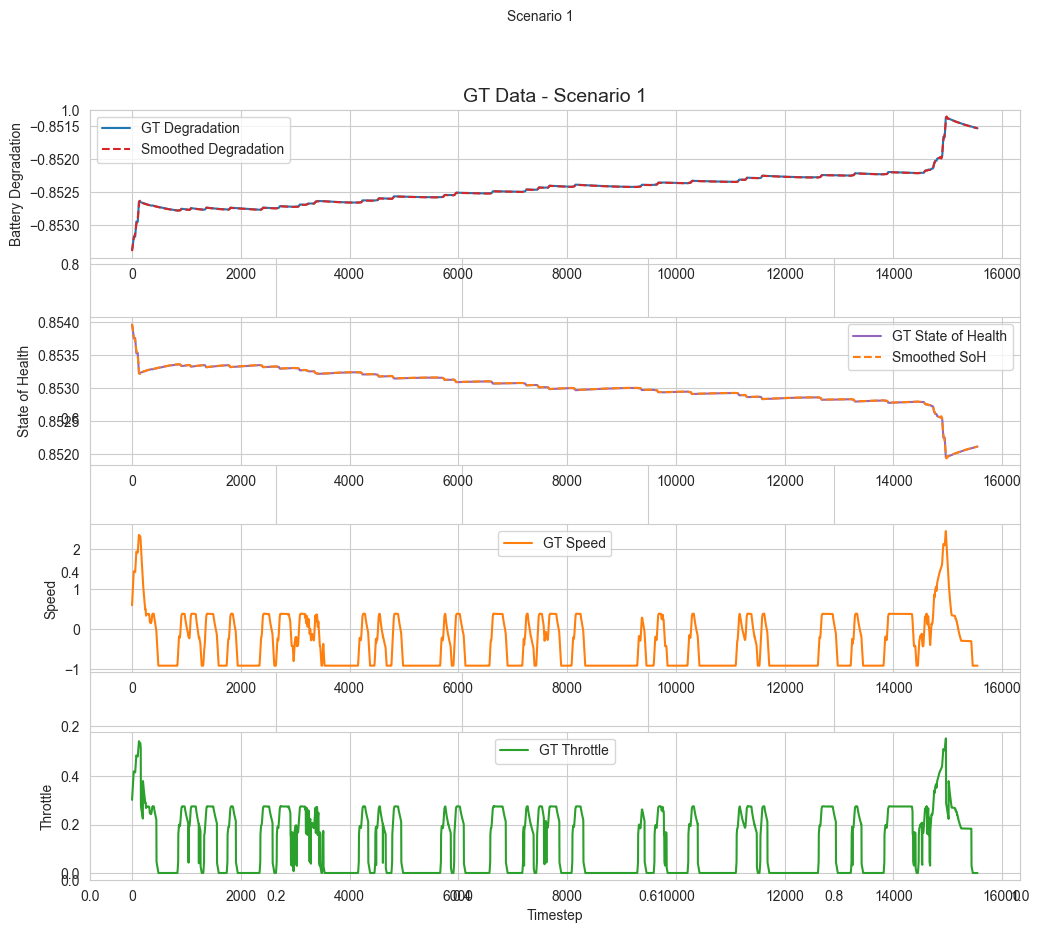

Processing scenario 2/4: sim_A5_mapTown02_soc1.0_temp7C_20250512_192507_aug.csv
Degradation stats - Mean: -0.84, Std: 0.00
Scenario 2: sim_A5_mapTown02_soc1.0_temp7C_20250512_192507_aug.csv


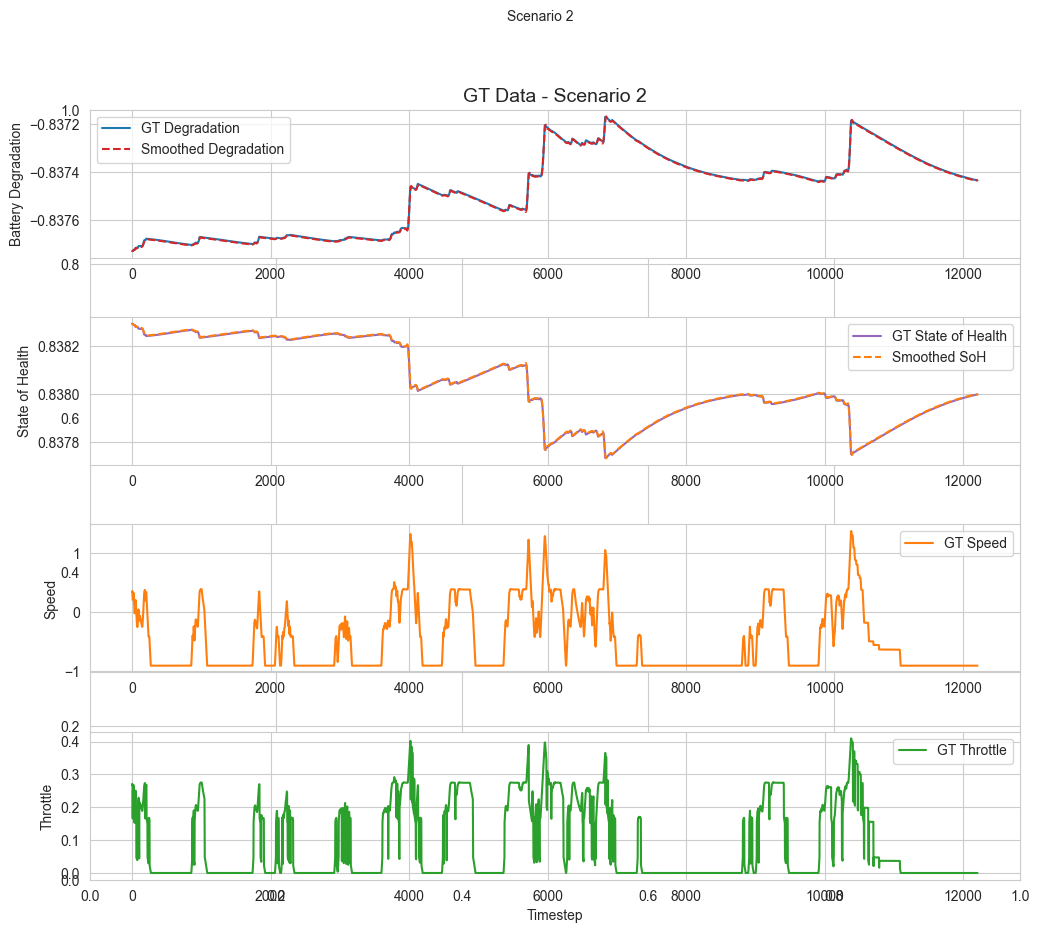

Processing scenario 3/4: sim_A5_mapTown05_soc1.0_temp40C_20250512_210557_aug.csv
Degradation stats - Mean: -0.81, Std: 0.02
Scenario 3: sim_A5_mapTown05_soc1.0_temp40C_20250512_210557_aug.csv


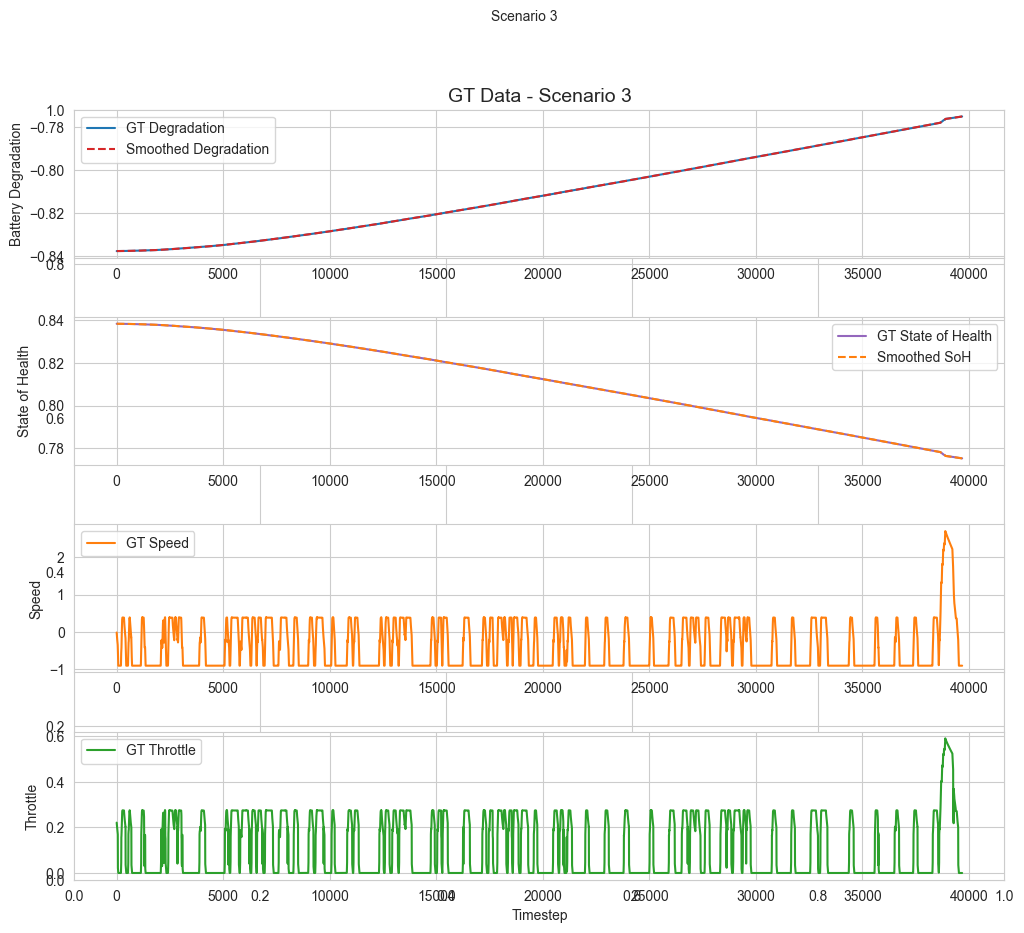

Processing scenario 4/4: sim_B5_mapTown05_soc1.0_temp30C_20250514_120440_aug.csv
Degradation stats - Mean: -0.32, Std: 0.01
Scenario 4: sim_B5_mapTown05_soc1.0_temp30C_20250514_120440_aug.csv


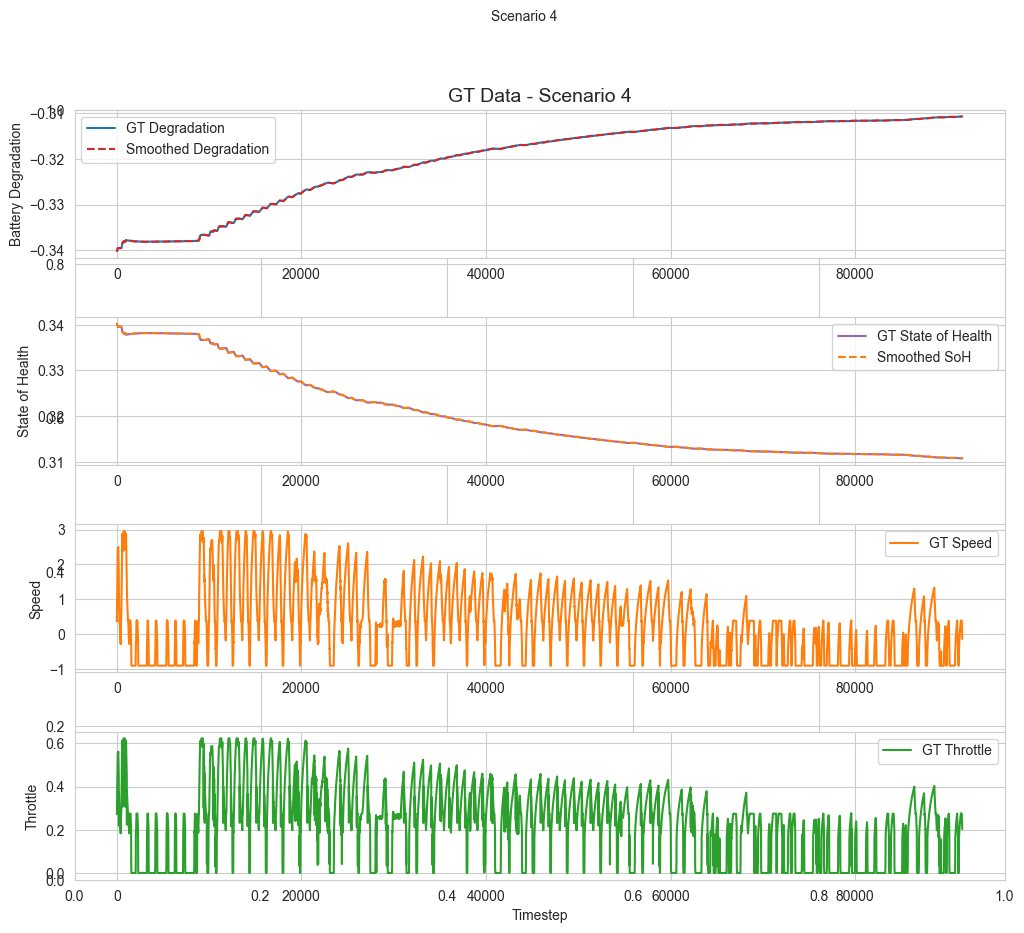

In [9]:
def plot_ground_truth(test_loader, deg_idx, speed_idx, throttle_idx, soh_idx, scenario_num, scenario_name=None):
    gt_deg, gt_speed, gt_throttle, gt_soh = [], [], [], []
    
    for states, actions, next_states, _, _ in test_loader:
        batch_deg = next_states[:, -1, deg_idx].cpu().numpy().flatten()
        gt_deg.extend(batch_deg)

        batch_SoH = next_states[:, -1, soh_idx].cpu().numpy().flatten()
        gt_soh.extend(batch_SoH)
        
        batch_speed = next_states[:, -1, speed_idx].cpu().numpy().flatten()
        gt_speed.extend(batch_speed)
        
        batch_throttle = actions[:, -1, throttle_idx].cpu().numpy().flatten()
        gt_throttle.extend(batch_throttle)
    
    t = np.arange(len(gt_deg))
    
    plt.figure(figsize=(12, 10))
    plt.title(f"GT Data - Scenario {scenario_num}", fontsize=14)
    plt.suptitle(f"Scenario: {scenario_name}" if scenario_name else f"Scenario {scenario_num}", fontsize=10)
    plt.subplots_adjust(hspace=0.4)

    plt.subplot(4, 1, 1)
    plt.plot(t, gt_deg, label="GT Degradation", color='tab:blue')
    plt.plot(t, savgol_filter(gt_deg, 128, 6), label="Smoothed Degradation", color='tab:red', linestyle='--')
    plt.ylabel("Battery Degradation")
    plt.legend()

    plt.subplot(4, 1, 2)
    plt.plot(t, gt_soh, label="GT State of Health", color='tab:purple')
    plt.plot(t, savgol_filter(gt_soh, 128, 6), label="Smoothed SoH", color='tab:orange', linestyle='--')
    plt.ylabel("State of Health")
    plt.legend()
    
    plt.subplot(4, 1, 3)
    plt.plot(t, gt_speed, label="GT Speed", color='tab:orange')
    plt.ylabel("Speed")
    plt.legend()
    
    plt.subplot(4, 1, 4)
    plt.plot(t, gt_throttle, label="GT Throttle", color='tab:green')
    plt.xlabel("Timestep")
    plt.ylabel("Throttle")
    plt.legend()
    
    #plt.tight_layout()
    plt.show()


# Get list of scenario files (adjust pattern if needed)
scenario_files = sorted([f for f in os.listdir(csv_dir) if f.endswith('.csv')])
print(f"Found {len(scenario_files)} scenarios in {csv_dir}")

for i, scenario_file in enumerate(scenario_files, 1):
    # Create path to individual scenario
    scenario_path = os.path.join(csv_dir, scenario_file)
    
    print(f"Processing scenario {i}/{len(scenario_files)}: {scenario_file}")

    # Prepare dataset for this scenario only
    test_ds, feature_cols, _ = prepare_dataset(
        csv_dir=scenario_path,
        unnormalised_cols=unnormalised_cols,
        numeric_cols=numeric_cols,
        categorical_cols=categorical_cols,
        action_cols=action_cols,
        seq_len=64,
        transformer=ct,
        is_test=True
    )  
    
    # Create loader with full dataset (batch_size=len(test_ds) to get all data)
    test_loader = DataLoader(test_ds, batch_size=len(test_ds), shuffle=False)
    
    # Get indices (should be same for all scenarios)
    deg_idx = feature_cols.index('num__sim_battery_degradation')
    speed_idx = feature_cols.index('num__sim_speed')
    soh_idx = feature_cols.index('num__sim_battery_soh')
    throttle_idx = action_cols.index('sim_throttle')
    
    # Add scenario name to the plot title
    print(f"Scenario {i}: {scenario_file}")

    # Plot this scenario
    plot_ground_truth(test_loader, deg_idx, speed_idx, throttle_idx, soh_idx, scenario_num=i)

Processing scenario 1/4
Degradation stats - Mean: -0.85, Std: 0.00


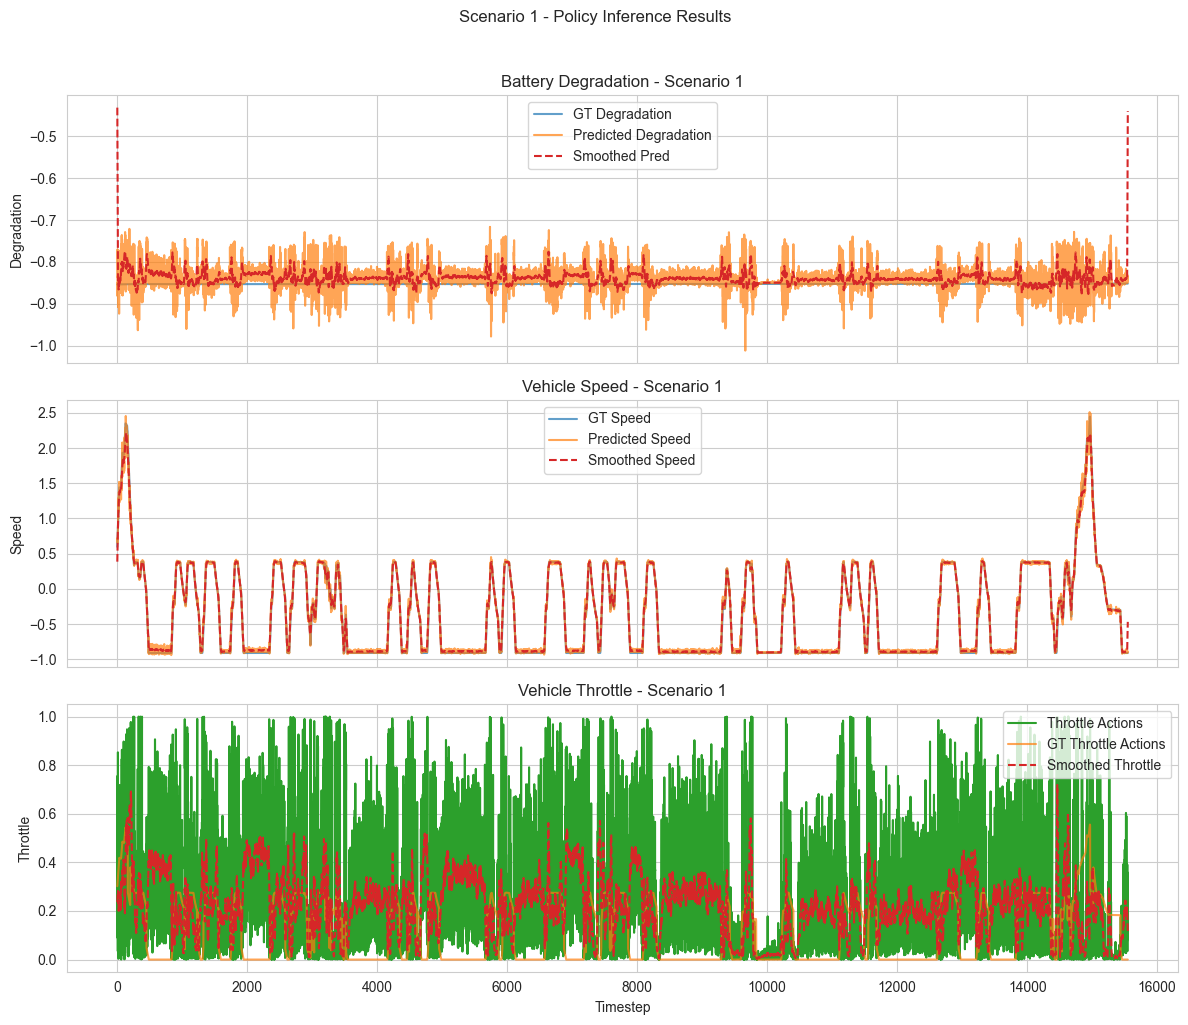

Processing scenario 2/4
Degradation stats - Mean: -0.84, Std: 0.00


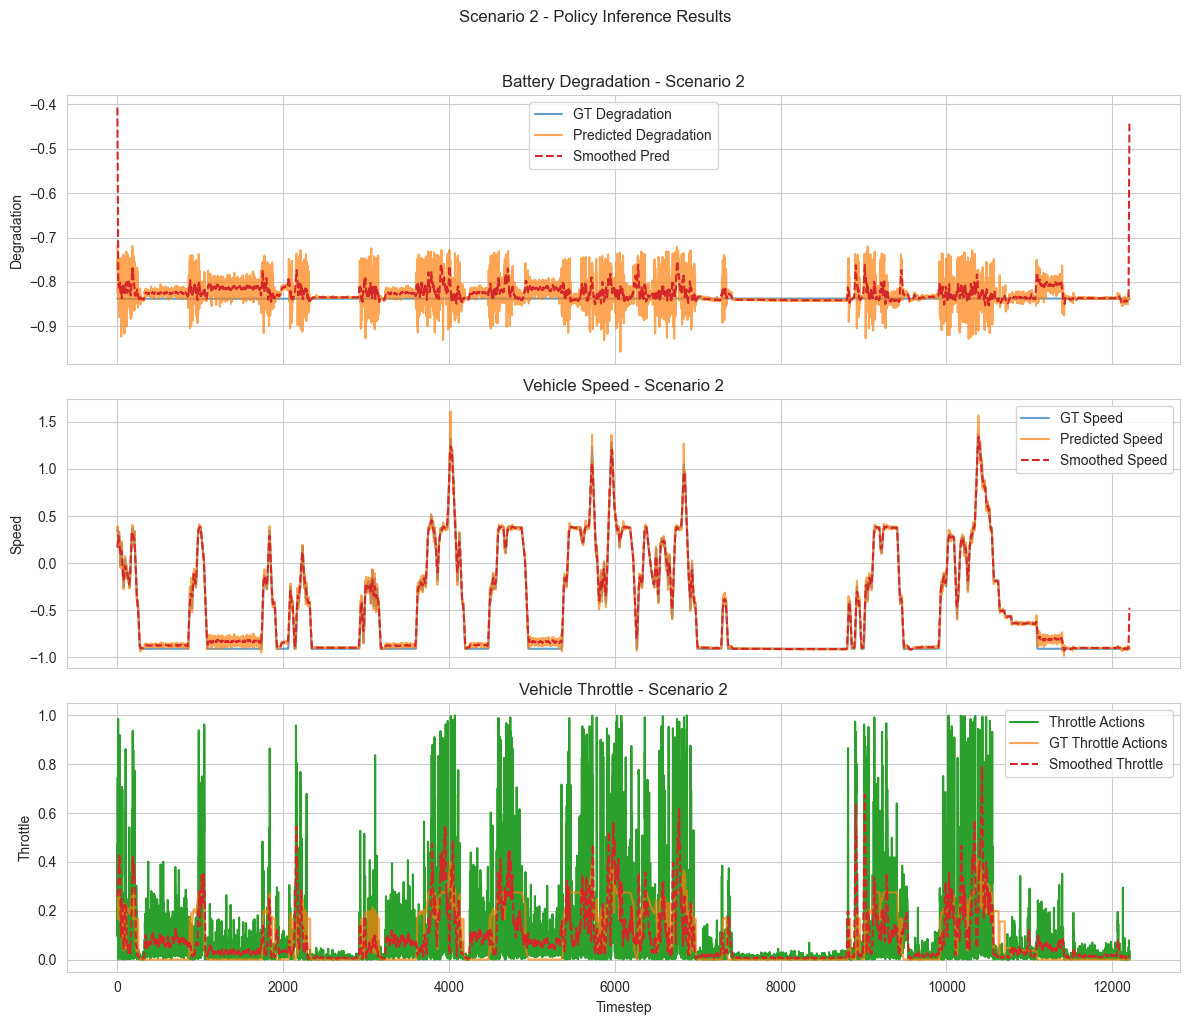

Processing scenario 3/4
Degradation stats - Mean: -0.81, Std: 0.02


KeyboardInterrupt: 

In [10]:
def run_all_scenario_inferences(csv_dir, **kwargs):
    scenario_files = sorted([os.path.join(csv_dir, f) 
                           for f in os.listdir(csv_dir) 
                           if f.endswith('.csv')])
    
    all_results = []
    for i, scenario_path in enumerate(scenario_files, 1):
        print(f"Processing scenario {i}/{len(scenario_files)}")
        results = sac_policy_windowed_inference(
            test_csv_path=scenario_path,
            scenario_num=i,  # Pass scenario number
            **kwargs
        )
        all_results.append(results)
    return all_results

results = run_all_scenario_inferences(
    csv_dir=csv_dir,
    state_cols=numeric_cols,
    action_cols=action_cols,
    actor_ckpt=model_actor,
    dynamics_ckpt=model,
    transformer=ct,
    seq_len=64,
    actor_hidden=128,
    dynamics_hidden=128,
)

# Access individual metrics:
#print("Average throttle:", results['throttle_actions'].mean())
#print("Speed MAE:", np.abs(results['gt_speed'] - results['pred_speed']).mean())
#print("Degradation RMSE:", np.sqrt(np.mean((results['gt_degradation'] - results['pred_degradation'])**2)))

In [ ]:
def mean_absolute_percentage_error(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """
    Compute the MAPE (in percent), skipping any points where y_true is zero.
    """
    # avoid division by zero
    nonzero = y_true != 0
    if not np.any(nonzero):
        return float('nan')
    mape = np.abs((y_true[nonzero] - y_pred[nonzero]) / y_true[nonzero])
    return 100.0 * mape.mean()

In [ ]:
scen = 3

mape_deg = mean_absolute_percentage_error(results[scen]['gt_degradation'], results[scen]['pred_degradation'])
print(f"Degradation MAPE: {mape_deg:.2f}%")

In [ ]:
total_gt_deg = np.trapezoid(results[scen]['gt_degradation'], dx=1)
total_pred_deg = np.trapezoid(results[scen]['pred_degradation'], dx=1)

# If positive: policy reduced degradation
# If negative: policy increased degradation
improvement_pct = (total_gt_deg - total_pred_deg)/total_gt_deg * 100
late_stage_improvement = np.mean(results[scen]['pred_degradation'][0:15000]) - np.mean(results[scen]['gt_degradation'][0:15000])

pprint(f"Improvement %: {improvement_pct:.3f}")
pprint(f"Late Improvement %: {late_stage_improvement:.3f}")

In [ ]:
def analyze_battery_policy(csv_path,
                          unnormalised_cols,
                          categorical_cols,
                          state_cols, 
                          action_cols,
                          actor_ckpt,
                          dynamics_ckpt,
                          transformer,
                          seq_len=64,
                          thin_step=100,     
                          smooth_win=21):
    """
    Comprehensive analysis of battery degradation and related parameters.
    
    Returns:
        dict: Dictionary containing key degradation metrics and comparisons
    """
    # ---------- Dataset Loading ----------
    test_ds = prepare_dataset(csv_dir=csv_path, 
                              unnormalised_cols=unnormalised_cols, 
                              numeric_cols=state_cols, 
                              categorical_cols=categorical_cols,
                              action_cols=action_cols, 
                              seq_len=seq_len, 
                              step=1, 
                              transformer=transformer,
                                is_test=True)
    test_loader = DataLoader(test_ds, batch_size=1, shuffle=False)

    # ---------- Model Loading ----------
    actor = Actor(len(state_cols), len(action_cols), NUM_LAYERS_ACT, HIDDEN_SIZE_SAC).to(DEVICE)
    actor.load_state_dict(torch.load(actor_ckpt))
    actor.eval()

    dynamics = DynamicsModel(len(state_cols), len(action_cols), 
                            NUM_LAYERS_DYN, HIDDEN_SIZE_DYN).to(DEVICE)
    dynamics.load_state_dict(torch.load(dynamics_ckpt))
    dynamics.eval()

    # ---------- Data Collection ----------
    metrics = {
        'gt_deg': [],        # Ground truth degradation
        'policy_deg': [],     # Policy-predicted degradation
        'gt_temp': [],        # Battery temperature
        'policy_temp': [],
        'gt_current': [],     # Battery current
        'policy_current': [],
        'gt_soc': [],         # State of charge
        'policy_soc': [],
        'throttle': [],       # Policy actions
        'steering': [],
        'gt_throttle': [],    # Historical actions
        'gt_steering': [],
    }

    # Index mappings
    deg_idx = state_cols.index('num__sim_battery_degradation')
    temp_idx = state_cols.index('num__sim_battery_temp')
    current_idx = state_cols.index('num__sim_battery_curr')
    soc_idx = state_cols.index('num__sim_battery_soc')
    throttle_idx = action_cols.index('sim_throttle')
    steering_idx = action_cols.index('carla_steering')

    with torch.no_grad():
        for states, actions, next_states, _, _ in test_loader:
            states = states.to(DEVICE)
            actions = actions.to(DEVICE)

            # Policy actions and dynamics predictions
            pol_act, _, _ = actor.sample(states)
            _, deg_pred, _, _ = dynamics(states, pol_act)
            
            # Store final step of each window
            final_step = -1
            
            # Ground truth (next state is the result of historical actions)
            metrics['gt_deg'].append(next_states[0, final_step, deg_idx].item())
            metrics['gt_temp'].append(next_states[0, final_step, temp_idx].item())
            metrics['gt_current'].append(next_states[0, final_step, current_idx].item())
            metrics['gt_soc'].append(next_states[0, final_step, soc_idx].item())
            
            # Policy results (predicted next state from policy actions)
            metrics['policy_deg'].append(deg_pred[0, final_step, 0].item())
            metrics['policy_temp'].append(states[0, final_step, temp_idx].item())  # Temp from current state
            metrics['policy_current'].append(states[0, final_step, current_idx].item())
            metrics['policy_soc'].append(states[0, final_step, soc_idx].item())
            
            # Actions
            metrics['throttle'].append(pol_act[0, final_step, 0].clamp(0, 1).item())
            metrics['steering'].append(pol_act[0, final_step, 1].clamp(-1, 1).item())
            metrics['gt_throttle'].append(actions[0, final_step, throttle_idx].item())
            metrics['gt_steering'].append(actions[0, final_step, steering_idx].item())

    # ---------- Metric Calculations ----------
    def _smooth(x, window):
        return savgol_filter(x, window_length=window, polyorder=3) if window > 1 else x

    analysis_results = {}
    
    # Cumulative Degradation Comparison
    analysis_results['cumulative_gt_deg'] = np.cumsum(metrics['gt_deg'])
    analysis_results['cumulative_policy_deg'] = np.cumsum(metrics['policy_deg'])
    
    # Degradation Rate Analysis
    analysis_results['avg_deg_rate_gt'] = np.mean(metrics['gt_deg'])
    analysis_results['avg_deg_rate_policy'] = np.mean(metrics['policy_deg'])
    analysis_results['deg_reduction_pct'] = (
        (analysis_results['avg_deg_rate_gt'] - analysis_results['avg_deg_rate_policy'])
        / analysis_results['avg_deg_rate_gt'] * 100
    )
    
    # Temperature Analysis
    analysis_results['max_temp_gt'] = np.max(metrics['gt_temp'])
    analysis_results['max_temp_policy'] = np.max(metrics['policy_temp'])
    
    # Action Analysis
    analysis_results['throttle_variation'] = np.std(metrics['throttle'])
    analysis_results['steering_variation'] = np.std(metrics['steering'])

    # ---------- Visualization ----------
    plt.figure(figsize=(15, 20))
    
    # Degradation Comparison
    plt.subplot(4, 1, 1)
    plt.plot(_smooth(metrics['gt_deg'], smooth_win), label='GT Degradation', alpha=0.7)
    plt.plot(_smooth(metrics['policy_deg'], smooth_win), label='Policy Degradation', alpha=0.7)
    plt.title(f"Battery Degradation Comparison\nPolicy Reduction: {analysis_results['deg_reduction_pct']:.1f}%")
    plt.ylabel("Degradation per Step")
    plt.legend()
    
    # Cumulative Degradation
    plt.subplot(4, 1, 2)
    plt.plot(analysis_results['cumulative_gt_deg'], label='GT Cumulative')
    plt.plot(analysis_results['cumulative_policy_deg'], label='Policy Cumulative')
    plt.title("Total Accumulated Degradation")
    plt.ylabel("Cumulative Degradation")
    plt.legend()
    
    # Battery Parameters
    plt.subplot(4, 1, 3)
    plt.plot(_smooth(metrics['gt_temp'], smooth_win), label='GT Temp', alpha=0.7)
    plt.plot(_smooth(metrics['policy_temp'], smooth_win), label='Policy Temp', alpha=0.7)
    plt.plot(_smooth(metrics['gt_current'], smooth_win), label='GT Current', alpha=0.7)
    plt.plot(_smooth(metrics['policy_current'], smooth_win), label='Policy Current', alpha=0.7)
    plt.title("Battery Temperature & Current")
    plt.ylabel("Normalized Values")
    plt.legend()
    
    # Action Comparison
    plt.subplot(4, 1, 4)
    plt.plot(_smooth(metrics['gt_throttle'], smooth_win), label='GT Throttle', alpha=0.7)
    plt.plot(_smooth(metrics['throttle'], smooth_win), label='Policy Throttle', alpha=0.7)
    plt.plot(_smooth(metrics['gt_steering'], smooth_win), label='GT Steering', alpha=0.7)
    plt.plot(_smooth(metrics['steering'], smooth_win), label='Policy Steering', alpha=0.7)
    plt.title("Action Comparison")
    plt.xlabel("Time Steps")
    plt.ylabel("Action Values")
    plt.legend()

    plt.tight_layout()
    plt.show()
    
    # ---------- Print Key Metrics ----------
    print("\nBattery Health Analysis Results:")
    print(f"• Average degradation rate reduction: {analysis_results['deg_reduction_pct']:.1f}%")
    print(f"• Max battery temperature (GT/Policy): {analysis_results['max_temp_gt']:.2f}/{analysis_results['max_temp_policy']:.2f}")
    print(f"• Throttle variation (σ): {analysis_results['throttle_variation']:.3f}")
    print(f"• Steering variation (σ): {analysis_results['steering_variation']:.3f}")

    return analysis_results

In [ ]:
results = analyze_battery_policy(
    csv_path=csv_dir,
    unnormalised_cols=unnormalised_cols,
    categorical_cols=categorical_cols,
    state_cols=numeric_cols,
    action_cols=action_cols,
    transformer=ct,
    actor_ckpt=model_actor,
    dynamics_ckpt=model
)

In [ ]:
def analyze_agent_behavior(agent, test_data):
    throttle_usage = []
    degradation_rates = []
    
    for batch in test_data:
        actions, _, _ = agent.actor.sample(batch.states)
        throttle = actions[:, :, 0]  # Throttle values
        
        throttle_usage.append(throttle.mean().item())
    
    print(f"Average throttle usage: {np.mean(throttle_usage):.3f}")
    print(f"Throttle std: {np.std(throttle_usage):.3f}")
    
    if np.mean(throttle_usage) < 0.1:
        print("⚠️  Agent learned 'no throttle' strategy")
    else:
        print("✅ Agent using varied throttle strategies")

In [ ]:
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False)

# Load models
actor = Actor(len(feature_cols), len(action_cols), num_layers=3, hidden_size=actor_hidden).to(device)
actor.load_state_dict(torch.load(actor_ckpt))
actor.eval()

analyze_agent_behavior()

### Test Agent Function

In [11]:
def test_agent_performance(actor_path, dynamics_path, test_csv_path, transformer, 
                          state_cols, action_cols, num_runs=10):
    """
    Test agent performance across multiple runs with different random seeds
    """
    results = []
    
    for run in range(num_runs):
        # Set random seed for reproducible results
        seed = 42 + run
        torch.manual_seed(seed)
        np.random.seed(seed)
        
        # Run inference
        metrics = sac_policy_windowed_inference(
            test_csv_path=test_csv_path,
            state_cols=state_cols,
            action_cols=action_cols,
            actor_ckpt=actor_path,
            dynamics_ckpt=dynamics_path,
            transformer=transformer,
            seq_len=64,
            device="cuda"
        )
        
        # Calculate performance metrics
        run_results = calculate_performance_metrics(metrics)
        run_results['seed'] = seed
        results.append(run_results)
        
        print(f"Run {run+1}/{num_runs} - Degradation RMSE: {run_results['degradation_rmse']:.4f}")
    
    return results

def calculate_performance_metrics(inference_results):
    """Calculate key performance metrics from inference results"""
    
    gt_deg = inference_results['gt_degradation']
    pred_deg = inference_results['pred_degradation']
    gt_speed = inference_results['gt_speed']
    pred_speed = inference_results['pred_speed']
    throttle = inference_results['throttle_actions']
    
    metrics = {
        # Degradation metrics
        'degradation_rmse': np.sqrt(np.mean((gt_deg - pred_deg)**2)),
        'degradation_mae': np.mean(np.abs(gt_deg - pred_deg)),
        'degradation_mape': np.mean(np.abs((gt_deg - pred_deg) / gt_deg)) * 100,
        
        # Speed metrics  
        'speed_mae': np.mean(np.abs(gt_speed - pred_speed)),
        'speed_rmse': np.sqrt(np.mean((gt_speed - pred_speed)**2)),
        
        # Action metrics
        'avg_throttle': np.mean(throttle),
        'throttle_std': np.std(throttle),
        'throttle_max': np.max(throttle),
        
        # Control stability
        'throttle_variability': np.std(np.diff(throttle)),  # How erratic throttle changes are
        'speed_stability': np.std(np.diff(pred_speed)),     # How smooth speed predictions are
    }
    return metrics

def calculate_performance_metrics(inference_results):
    """Calculate key performance metrics from inference results"""
    
    gt_deg = inference_results['gt_degradation']
    pred_deg = inference_results['pred_degradation']
    gt_speed = inference_results['gt_speed']
    pred_speed = inference_results['pred_speed']
    throttle = inference_results['throttle_actions']
    
    metrics = {
        # Degradation metrics
        'degradation_rmse': np.sqrt(np.mean((gt_deg - pred_deg)**2)),
        'degradation_mae': np.mean(np.abs(gt_deg - pred_deg)),
        'degradation_mape': np.mean(np.abs((gt_deg - pred_deg) / gt_deg)) * 100,
        
        # Speed metrics  
        'speed_mae': np.mean(np.abs(gt_speed - pred_speed)),
        'speed_rmse': np.sqrt(np.mean((gt_speed - pred_speed)**2)),
        
        # Action metrics
        'avg_throttle': np.mean(throttle),
        'throttle_std': np.std(throttle),
        'throttle_max': np.max(throttle),
        
        # Control stability
        'throttle_variability': np.std(np.diff(throttle)),  # How erratic throttle changes are
        'speed_stability': np.std(np.diff(pred_speed)),     # How smooth speed predictions are
    }
    
    return metrics

### Baseline Comparison Functions

In [12]:
def test_random_policy(test_csv_path, transformer, state_cols, action_cols, num_runs=10):
    """Test random policy performance"""
    results = []
    
    for run in range(num_runs):
        seed = 42 + run
        np.random.seed(seed)
        
        # Load test data
        test_ds, feature_cols, _ = prepare_dataset(
            csv_dir=test_csv_path,
            unnormalised_cols=[],
            numeric_cols=state_cols, 
            categorical_cols=[],
            action_cols=action_cols,
            seq_len=64,
            transformer=transformer,
            is_test=True
        )
        test_loader = DataLoader(test_ds, batch_size=1, shuffle=False)
        
        # Generate random actions and collect metrics
        gt_deg, pred_deg = [], []
        gt_speed, pred_speed = [], []
        throttle_actions = []
        
        deg_idx = feature_cols.index('num__sim_battery_degradation')
        speed_idx = feature_cols.index('num__sim_speed')
        
        with torch.no_grad():
            for states, actions, next_states, _, _ in test_loader:
                # Random actions between 0 and 1
                random_actions = torch.rand_like(actions)
                
                # Use dynamics model with random actions
                _, deg_pred, _, speed_pred, _ = dynamics_model(states.to("cuda"), random_actions.to("cuda"))
                
                # Store metrics
                gt_deg.append(next_states[0, -1, deg_idx].item())
                pred_deg.append(deg_pred[0, -1, 0].cpu().item())
                gt_speed.append(next_states[0, -1, speed_idx].item())
                pred_speed.append(speed_pred[0, -1, 0].cpu().item())
                throttle_actions.append(random_actions[0, -1, 0].item())
        
        # Calculate metrics
        metrics = calculate_performance_metrics({
            'gt_degradation': np.array(gt_deg),
            'pred_degradation': np.array(pred_deg),
            'gt_speed': np.array(gt_speed),
            'pred_speed': np.array(pred_speed),
            'throttle_actions': np.array(throttle_actions)
        })
        
        results.append(metrics)
    
    return results

def test_ground_truth_policy(test_csv_path, transformer, state_cols, action_cols, num_runs=10):
    """Test using original ground truth actions (behavioral cloning baseline)"""
    results = []
    
    for run in range(num_runs):
        # Similar to random policy but use original actions from dataset
        # Implementation similar to above but use actions from test_loader directly
        pass  # Implement based on your specific needs
    
    return results

### Statistical Comparison with Welch's

In [13]:
def statistical_comparison(sac_results, baseline_results, metric_name='degradation_rmse'):
    """
    Perform Welch's t-test to compare SAC vs baseline performance
    """
    
    # Extract metric values
    sac_values = [r[metric_name] for r in sac_results]
    baseline_values = [r[metric_name] for r in baseline_results]
    
    # Welch's t-test (assumes unequal variances)
    t_stat, p_value = stats.ttest_ind(sac_values, baseline_values, equal_var=False)
    
    # Calculate effect size (Cohen's d)
    pooled_std = np.sqrt((np.var(sac_values, ddof=1) + np.var(baseline_values, ddof=1)) / 2)
    cohens_d = (np.mean(sac_values) - np.mean(baseline_values)) / pooled_std
    
    # 95% confidence intervals
    sac_ci = stats.t.interval(0.95, len(sac_values)-1, 
                              loc=np.mean(sac_values), 
                              scale=stats.sem(sac_values))
    baseline_ci = stats.t.interval(0.95, len(baseline_values)-1,
                                   loc=np.mean(baseline_values),
                                   scale=stats.sem(baseline_values))
    
    results = {
        'metric': metric_name,
        'sac_mean': np.mean(sac_values),
        'sac_std': np.std(sac_values),
        'sac_ci': sac_ci,
        'baseline_mean': np.mean(baseline_values), 
        'baseline_std': np.std(baseline_values),
        'baseline_ci': baseline_ci,
        't_statistic': t_stat,
        'p_value': p_value,
        'cohens_d': cohens_d,
        'significant': p_value < 0.05,
        'improvement_percent': ((np.mean(baseline_values) - np.mean(sac_values)) / np.mean(baseline_values)) * 100
    }
    
    return results

def comprehensive_statistical_analysis():
    """Run complete statistical analysis"""
    
    print("🔬 Running Statistical Performance Analysis...")
    
    print("Testing SAC Agent...")
    sac_results = test_agent_performance(
        actor_path="path/to/sac_actor.pth",
        dynamics_path="path/to/dynamics_model.pth", 
        test_csv_path="path/to/test/data",
        transformer=ct,
        state_cols=numeric_cols,
        action_cols=action_cols,
        num_runs=10
    )
    
    # Test random baseline
    print("Testing Random Policy Baseline...")
    random_results = test_random_policy(
        test_csv_path="path/to/test/data",
        transformer=ct,
        state_cols=numeric_cols, 
        action_cols=action_cols,
        num_runs=10
    )
    
    # Statistical comparisons
    metrics_to_compare = ['degradation_rmse', 'degradation_mae', 'speed_mae', 'avg_throttle']
    
    print("\n📊 Statistical Comparison Results:")
    print("="*70)
    
    for metric in metrics_to_compare:
        stats_result = statistical_comparison(sac_results, random_results, metric)
        
        print(f"\n🎯 {metric.upper()}:")
        print(f"   SAC:      {stats_result['sac_mean']:.4f} ± {stats_result['sac_std']:.4f}")
        print(f"   Random:   {stats_result['baseline_mean']:.4f} ± {stats_result['baseline_std']:.4f}")
        print(f"   t-stat:   {stats_result['t_statistic']:.3f}")
        print(f"   p-value:  {stats_result['p_value']:.6f}")
        print(f"   Cohen's d: {stats_result['cohens_d']:.3f}")
        print(f"   Improvement: {stats_result['improvement_percent']:.2f}%")
        
        if stats_result['significant']:
            print(f"   ✅ STATISTICALLY SIGNIFICANT")
        else:
            print(f"   ❌ NOT STATISTICALLY SIGNIFICANT")
    
    return sac_results, random_results

# Run the analysis
sac_results, random_results = comprehensive_statistical_analysis()

🔬 Running Statistical Performance Analysis...
Testing SAC Agent...


ValueError: Invalid path: path/to/test/data

In [14]:
def calculate_performance_metrics(inference_results):
    """Calculate key performance metrics from inference results"""
    
    gt_deg = inference_results['gt_degradation']
    pred_deg = inference_results['pred_degradation']
    gt_speed = inference_results['gt_speed']
    pred_speed = inference_results['pred_speed']
    throttle = inference_results['throttle_actions']
    
    metrics = {
        # Degradation metrics
        'degradation_rmse': np.sqrt(np.mean((gt_deg - pred_deg)**2)),
        'degradation_mae': np.mean(np.abs(gt_deg - pred_deg)),
        'degradation_mape': np.mean(np.abs((gt_deg - pred_deg) / gt_deg)) * 100,
        
        # Speed metrics  
        'speed_mae': np.mean(np.abs(gt_speed - pred_speed)),
        'speed_rmse': np.sqrt(np.mean((gt_speed - pred_speed)**2)),
        
        # Action metrics
        'avg_throttle': np.mean(throttle),
        'throttle_std': np.std(throttle),
        'throttle_max': np.max(throttle),
        
        # Control stability
        'throttle_variability': np.std(np.diff(throttle)),  # How erratic throttle changes are
        'speed_stability': np.std(np.diff(pred_speed)),     # How smooth speed predictions are
    }
    
    return metrics

In [15]:
actor = Actor(len(feature_cols), len(action_cols), num_layers=3, hidden_size=128)
actor.load_state_dict(torch.load(model_actor))

critic = Critic(len(feature_cols), len(action_cols), num_layers=4, hidden_size=128)
critic.load_state_dict(torch.load(model_critic))

dynamics = DynamicsModel(len(feature_cols), len(action_cols), num_layers=3, hidden_size=128)
dynamics.load_state_dict(torch.load(model))

# Export 
def export_models_for_netron(dynamics_model, feature_cols, action_cols, actor, critic):
    # Get dimensions from feature/action lists
    state_dim = len(feature_cols)
    action_dim = len(action_cols)
    seq_len = 64  # Match your training sequence length
    
    # Create dummy inputs with correct shapes
    dummy_states = torch.randn(1, seq_len, state_dim)  # [batch, seq, features]
    dummy_actions = torch.randn(1, seq_len, action_dim)
    
    # Export Dynamics Model
    torch.onnx.export(
        dynamics_model,
        (dummy_states, dummy_actions),  # Pass tensors, not feature names
        "dynamics_model.onnx",
        input_names=['states', 'actions'],
        output_names=['state_pred', 'deg_pred', 'range_pred', 'speed_pred', 'hidden'],
        dynamic_axes={
            'states': {0: 'batch_size', 1: 'sequence'}, 
            'actions': {0: 'batch_size', 1: 'sequence'},
            'state_pred': {0: 'batch_size', 1: 'sequence'},
            'hidden': {0: 'batch_size', 1: 'sequence'}
        }
    )
    
    # Export Actor Network (only needs states)
    torch.onnx.export(
        actor,
        dummy_states,
        "actor_network.onnx",
        input_names=['states'],
        output_names=['mean', 'log_std', 'hidden'],
        dynamic_axes={
            'states': {0: 'batch_size', 1: 'sequence'},
            'mean': {0: 'batch_size', 1: 'sequence'},
            'log_std': {0: 'batch_size', 1: 'sequence'}
        }
    )
    
    # Export Critic Network (needs both states and actions)
    torch.onnx.export(
        critic,
        (dummy_states, dummy_actions),
        "critic_network.onnx",
        input_names=['states', 'actions'],
        output_names=['q1', 'q2'],
        dynamic_axes={
            'states': {0: 'batch_size', 1: 'sequence'},
            'actions': {0: 'batch_size', 1: 'sequence'},
            'q1': {0: 'batch_size', 1: 'sequence'},
            'q2': {0: 'batch_size', 1: 'sequence'}
        }
    )

In [16]:
export_models_for_netron(dynamics, feature_cols, action_cols, actor, critic) # Export and visualize
#netron.start("dynamics_model.onnx")
#netron.start("actor_network.onnx")
#netron.start("critic_network.onnx")

f:\Onedrive\Uni\MSc_uddannelse\4_semester\KandidatThesis\Thesis_Implementation\Scripts\MSc_python_venv\lib\site-packages\torch\onnx\symbolic_opset9.py:4244: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with LSTM can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  warnings.warn(


In [17]:
def export_actor_onnx(actor, onnx_path, state_dim, hidden_size, num_layers):
    """Export actor for deployment with hidden state handling"""
    actor_cpu = actor.to("cpu").eval()
    #actor.eval()
    len_seq = 64
    # Create sample inputs
    dummy_states = torch.randn(1, len_seq, state_dim)  # [batch, seq, features]
    
    # Export Actor Network (only needs states)
    torch.onnx.export(
        actor_cpu,
        dummy_states,
        "actor_network.onnx",
        input_names=['states'],
        output_names=['mean', 'log_std', 'hidden'],
        dynamic_axes={
            'states': {0: 'batch_size', 1: 'sequence'},
            'mean': {0: 'batch_size', 1: 'sequence'},
            'log_std': {0: 'batch_size', 1: 'sequence'}
        }
    )

def export_critic_onnx(critic, onnx_path, state_dim, action_dim):
    """Export critic for deployment"""
    critic_cpu = critic.to("cpu").eval()
    len_seq = 64

    # Create sample inputs
    dummy_state = torch.randn(1, len_seq, state_dim)  # [batch, seq, features]
    dummy_actions = torch.randn(1, len_seq, action_dim)  # [batch, seq, actions]
    
    # Export Critic Network (needs both states and actions)
    torch.onnx.export(
        critic_cpu,
        (dummy_state, dummy_actions),
        "critic_network.onnx",
        input_names=['states', 'actions'],
        output_names=['q1', 'q2'],
        dynamic_axes={
            'states': {0: 'batch_size', 1: 'sequence'},
            'actions': {0: 'batch_size', 1: 'sequence'},
            'q1': {0: 'batch_size', 1: 'sequence'},
            'q2': {0: 'batch_size', 1: 'sequence'}
        }
    )

def benchmark_actor(model, device, sequence_length=1000, warmup=10):
    """Benchmark actor in deployment mode (step-by-step)"""
    model.to(device)
    model.eval()
    
    #if state_dim is None:
    state_dim = model.state_dim
    
    # Create test sequence
    states = torch.randn(sequence_length, state_dim).to(device)
    times = []
    hidden = None
    
    # Warmup
    for i in range(warmup):
        with torch.no_grad():
            _, _, hidden = model.step(states[i])
            if device == "cuda":
                torch.cuda.synchronize()
    
    # Benchmark
    hidden = None
    for i in range(sequence_length):
        with torch.no_grad():
            start = time.time()
            _, _, hidden = model.step(states[i])
            if device == "cuda":
                torch.cuda.synchronize()
            end = time.time()
            times.append(end - start)
    
    return times

def benchmark_critic(model, device, batch_size=1, seq_len=64, num_batches=100, warmup=10):
    """Benchmark critic network"""
    model.to(device)
    model.eval()
    state_dim = model.state_dim
    action_dim = model.action_dim
    
    # Create test batches
    states = torch.randn(num_batches, batch_size, seq_len, state_dim).to(device)
    actions = torch.randn(num_batches, batch_size, seq_len, action_dim).to(device)
    times = []
    
    # Warmup
    for i in range(warmup):
        with torch.no_grad():
            _ = model(states[i], actions[i])
            if device == "cuda":
                torch.cuda.synchronize()
    
    # Benchmark
    for i in range(num_batches):
        with torch.no_grad():
            start = time.time()
            _ = model(states[i], actions[i])
            if device == "cuda":
                torch.cuda.synchronize()
            end = time.time()
            times.append(end - start)
    
    return times

def benchmark_onnx_actor(onnx_path,
                         provider="CPUExecutionProvider",
                         sequence_length=100,
                         warmup=10,
                         fallback_seq_len=64):
    """
    Works for
      • new export  : single input  (states)           → no hidden handling
      • old export  : three inputs (state, h0, c0)     → keeps hidden loop
    """
    sess = ort.InferenceSession(onnx_path, providers=[provider])

    # ---------- infer signature ------------------------------------------------
    inp_names   = [i.name for i in sess.get_inputs()]
    has_hidden  = len(inp_names) == 3
    state_name  = inp_names[0]                       # "states"  or "state"

    # concrete sizes – fall back to defaults if dynamic
    in_shape    = sess.get_inputs()[0].shape         # e.g. [None, 'sequence', 73]
    state_dim   = in_shape[-1]                       # always an int
    seq_len     = in_shape[-2] if isinstance(in_shape[-2], int) else fallback_seq_len

    # ---------- generate dummy data -------------------------------------------
    if has_hidden:
        hidden_size = sess.get_inputs()[1].shape[-1]
        n_layers    = sess.get_inputs()[1].shape[0]
        h = np.zeros((n_layers, 1, hidden_size), dtype=np.float32)
        c = np.zeros_like(h)

    states = np.random.randn(sequence_length, 1, seq_len, state_dim).astype(np.float32)

    # ---------- warm-up --------------------------------------------------------
    for i in range(warmup):
        if has_hidden:
            sess.run(None, {state_name: states[i], "h0": h, "c0": c})
        else:
            sess.run(None, {state_name: states[i]})

    # ---------- timed loop -----------------------------------------------------
    times = []
    if has_hidden:
        h = np.zeros_like(h)
        c = np.zeros_like(c)

    for i in range(sequence_length):
        start = time.time()
        if has_hidden:
            out = sess.run(None, {state_name: states[i], "h0": h, "c0": c})
            h, c = out[-2], out[-1]                         # keep hidden
        else:
            sess.run(None, {state_name: states[i]})
        times.append(time.time() - start)

    return times

def benchmark_onnx_critic(onnx_path,
                          provider="CPUExecutionProvider",
                          num_batches=100,
                          warmup=10,
                          fallback_seq_len=64):
    """
    Benchmarks Critic(states, actions) -> (q1,q2) ONNX graph.
    Works whether the sequence length is fixed or declared dynamic.
    """
    sess = ort.InferenceSession(onnx_path, providers=[provider])

    s_name, a_name = [i.name for i in sess.get_inputs()]
    q1_name        = sess.get_outputs()[0].name

    # -----------------------------------------------------------------
    # concrete sizes – if shape element is a string (dynamic), fall back
    # -----------------------------------------------------------------
    s_shape  = sess.get_inputs()[0].shape     # [None, 'sequence', state_dim]
    a_shape  = sess.get_inputs()[1].shape

    seq_len  = (s_shape[-2] if isinstance(s_shape[-2], int)
                else fallback_seq_len)                      # △
    state_dim = s_shape[-1]
    action_dim = a_shape[-1]

    # -----------------------------------------------------------------
    # dummy data
    # -----------------------------------------------------------------
    states  = np.random.randn(num_batches, 1, seq_len, state_dim
                              ).astype(np.float32)
    actions = np.random.randn(num_batches, 1, seq_len, action_dim
                              ).astype(np.float32)

    # warm-up
    for i in range(warmup):
        sess.run([q1_name], {s_name: states[i], a_name: actions[i]})

    # timed loop
    times = []
    for i in range(num_batches):
        start = time.time()
        sess.run([q1_name], {s_name: states[i], a_name: actions[i]})
        times.append(time.time() - start)

    return times


In [18]:
def run_sac_benchmark(onnx_path, actor, critic, state_dim, action_dim, hidden_size, num_layers):
    results = []
    
    # Benchmark Actor
    print("Benchmarking Actor on CPU...")
    times = benchmark_actor(actor, device="cpu", sequence_length=100)
    results.extend([{'Component': 'Actor', 'Device': 'CPU', 'Latency (s)': t} for t in times])
    
    if torch.cuda.is_available():
        print("Benchmarking Actor on GPU...")
        times = benchmark_actor(actor, device=DEVICE, sequence_length=100)
        results.extend([{'Component': 'Actor', 'Device': 'GPU', 'Latency (s)': t} for t in times])
    
    # Benchmark Critic
    print("Benchmarking Critic on CPU...")
    times = benchmark_critic(critic, device="cpu")
    results.extend([{'Component': 'Critic', 'Device': 'CPU', 'Latency (s)': t} for t in times])
    
    if torch.cuda.is_available():
        print("Benchmarking Critic on GPU...")
        times = benchmark_critic(critic, device=DEVICE)
        results.extend([{'Component': 'Critic', 'Device': 'GPU', 'Latency (s)': t} for t in times])
    
    # ONNX Export and Benchmark
    onnx_path_actor = onnx_path / "actor_network.onnx"
    export_actor_onnx(actor, onnx_path_actor, state_dim, hidden_size, num_layers)
    
    onnx_path_critic = onnx_path / "critic_network.onnx"
    export_critic_onnx(critic, onnx_path_critic, state_dim, action_dim)

    print("Benchmarking ONNX Actor on CPU...")
    times = benchmark_onnx_actor(onnx_path_actor, provider="CPUExecutionProvider")
    results.extend([{'Component': 'Actor-ONNX', 'Device': 'CPU', 'Latency (s)': t} for t in times])
    
    if 'CUDAExecutionProvider' in ort.get_available_providers():
        print("Benchmarking ONNX Actor on GPU...")
        times = benchmark_onnx_actor(onnx_path_actor, provider="CUDAExecutionProvider")
        results.extend([{'Component': 'Actor-ONNX', 'Device': 'GPU', 'Latency (s)': t} for t in times])

    print("Benchmarking ONNX Critic on CPU...")
    times = benchmark_onnx_critic(onnx_path_critic, provider="CPUExecutionProvider")
    results.extend([{'Component': 'Critic-ONNX', 'Device': 'CPU', 'Latency (s)': t} for t in times])
    
    if 'CUDAExecutionProvider' in ort.get_available_providers():
        print("Benchmarking ONNX Critic on GPU...")
        times = benchmark_onnx_critic(onnx_path_critic, provider="CUDAExecutionProvider")
        results.extend([{'Component': 'Critic-ONNX', 'Device': 'GPU', 'Latency (s)': t} for t in times])

    return pd.DataFrame(results)

In [19]:
def plot_sac_results(df, save_as="sac_benchmark_results.png"):
    sns.set_style("whitegrid")
    fig = plt.figure(figsize=(13, 6))
    gs  = gridspec.GridSpec(1, 2, width_ratios=[1,1], wspace=0.35)

    # --- Actor --------------------------------------------------
    ax0 = fig.add_subplot(gs[0])
    actor_df = df[df['Component'].str.contains('Actor')]
    sns.boxplot(data=actor_df,
                x='Device', y='Latency (s)', hue='Component', ax=ax0)
    ax0.set_yscale('log')
    ax0.set_title("Actor Latency")
    ax0.legend(title="Component", loc="upper left")

    # --- Critic -------------------------------------------------
    ax1 = fig.add_subplot(gs[1])
    critic_df = df[df['Component'].str.contains('Critic')]
    sns.boxplot(data=critic_df, x='Device', y='Latency (s)', hue='Component', ax=ax1)
    ax1.set_yscale('log')
    ax1.set_title("Critic Latency")
    ax1.legend_.remove()

    # tight-layout & save
    plt.tight_layout()
    plt.savefig(save_as, dpi=150)
    plt.show()

def print_sac_latency_summary(df):
    summary = df.groupby(['Component', 'Device'])['Latency (s)'].agg(
        Mean='mean',
        Median='median',
        StdDev='std',  # Added standard deviation
        P90=lambda x: x.quantile(0.9),
        Min='min',
        Max='max'
    ).reset_index()
    
    # Convert to milliseconds for readability
    summary[['Mean', 'Median', 'StdDev', 'P90', 'Min', 'Max']] *= 1000
    
    print("\nSAC Component Latency Summary (ms):")
    print(summary.to_string(index=False, float_format="{:.4f}".format))
    
    # Check real-time feasibility
    real_time_threshold = 100  # ms (10 Hz requirement)
    actor_onnx_cpu = summary[
        (summary['Component'] == 'Actor-ONNX') & 
        (summary['Device'] == 'CPU')
    ]['Median'].values[0]
    
    print(f"\nReal-time Feasibility (10Hz = 100ms limit):")
    print(f"Actor ONNX CPU Median: {actor_onnx_cpu:.4f} ms - {'✅' if actor_onnx_cpu < real_time_threshold else '❌'}")
    
    return summary

Benchmarking Actor on CPU...
Benchmarking Actor on GPU...
Benchmarking Critic on CPU...
Benchmarking Critic on GPU...


f:\Onedrive\Uni\MSc_uddannelse\4_semester\KandidatThesis\Thesis_Implementation\Scripts\MSc_python_venv\lib\site-packages\torch\onnx\symbolic_opset9.py:4244: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with LSTM can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  warnings.warn(


Benchmarking ONNX Actor on CPU...
Benchmarking ONNX Actor on GPU...
Benchmarking ONNX Critic on CPU...
Benchmarking ONNX Critic on GPU...


C:\Users\Mikkel\AppData\Local\Temp\ipykernel_10988\1926140338.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


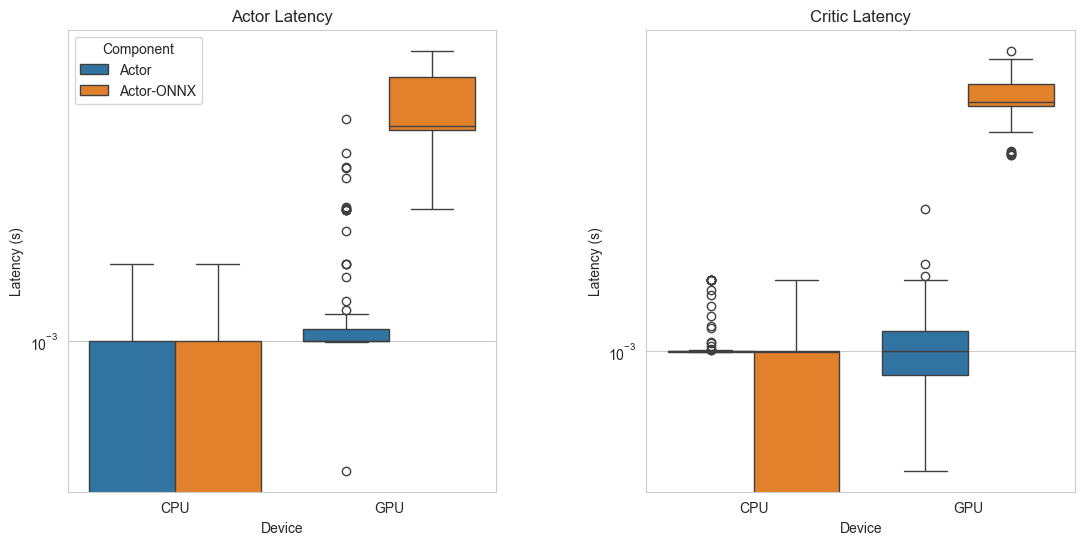


SAC Component Latency Summary (ms):
  Component Device   Mean  Median  StdDev    P90    Min    Max
      Actor    CPU 0.4591  0.0000  0.5313 1.0036 0.0000 1.5044
      Actor    GPU 1.0301  1.0002  0.6301 1.9971 0.0000 3.2344
 Actor-ONNX    CPU 0.4979  0.0000  0.5234 1.0006 0.0000 1.5049
 Actor-ONNX    GPU 3.3287  3.1226  0.6576 4.1572 2.0072 4.6394
     Critic    CPU 0.8734  1.0002  0.4518 1.3883 0.0000 1.5051
     Critic    GPU 0.8607  1.0003  0.5286 1.4640 0.0000 2.2688
Critic-ONNX    CPU 0.6208  0.9986  0.5633 1.2827 0.0000 1.5047
Critic-ONNX    GPU 4.3228  4.2026  0.5461 5.1194 3.0918 5.6279

Real-time Feasibility (10Hz = 100ms limit):
Actor ONNX CPU Median: 0.0000 ms - ✅
Layer (type:depth-idx)                   Output Shape              Param #
Actor                                    [1, 64, 2]                --
├─LSTM: 1-1                              [1, 64, 128]              342,016
├─Linear: 1-2                            [1, 64, 128]              16,512
├─Linear: 1-3       

In [22]:
#file system paths
sac_model_dir = Path(f"F:/Onedrive/Uni/MSc_uddannelse/4_semester/KandidatThesis/Thesis_Implementation/Scripts/RL_network/checkpoints/SAC_run_0dbb/")
actor_file = sac_model_dir / "sac_actor.pth"
critic_file = sac_model_dir / "sac_critic.pth"

#setup actor and critic models
actor = Actor(len(feature_cols), len(action_cols), num_layers=3, hidden_size=128).to(DEVICE)
actor.load_state_dict(torch.load(actor_file))

critic = Critic(len(feature_cols), len(action_cols), num_layers=4, hidden_size=128).to(DEVICE)
critic.load_state_dict(torch.load(critic_file))

dummy_state = torch.randn(1, 64, 22)  # [batch, seq, features]
dummy_actions = torch.randn(1, 64, 22)  
actor_summary = torch_summary(actor, [(1, 64, len(feature_cols))], depth=2)
critic_summary = torch_summary(critic, [(1, 64, len(feature_cols)), (1, 64, len(action_cols))], depth=2)

benchmark_df = run_sac_benchmark(
    sac_model_dir,
    actor,
    critic,
    state_dim=len(feature_cols),
    action_dim=len(action_cols),
    hidden_size=HIDDEN_SIZE_SAC,
    num_layers=NUM_LAYERS_ACT
)

plot_sac_results(benchmark_df)
summary_table = print_sac_latency_summary(benchmark_df)

pprint(actor_summary)
pprint(critic_summary)

In [ ]:
def export_latency_table(summary_df, to_latex=True, to_markdown=True):
    if to_latex:
        latex = summary_df.to_latex(index=False, float_format="%.6f")
        print("\n📄 LaTeX Table:")
        print(latex)

    if to_markdown:
        md = summary_df.to_markdown(index=False, floatfmt=".6f")
        print("\n📝 Markdown Table:")
        print(md)

In [ ]:
export_latency_table(summary_table, to_latex=True, to_markdown=False)


📄 LaTeX Table:
\begin{tabular}{llrrrrr}
\toprule
Component & Device & Mean & Median & P90 & Min & Max \\
\midrule
Actor & CPU & 0.439246 & 0.000000 & 1.011848 & 0.000000 & 1.505613 \\
Actor & GPU & 0.880761 & 1.003385 & 1.436782 & 0.000000 & 2.281666 \\
Actor-ONNX & CPU & 0.515120 & 0.504375 & 1.000643 & 0.000000 & 1.505613 \\
Actor-ONNX & GPU & 3.536863 & 3.267646 & 5.006027 & 2.032518 & 6.018400 \\
Critic & CPU & 0.885720 & 1.000166 & 1.504421 & 0.000000 & 1.552582 \\
Critic & GPU & 0.859184 & 1.000762 & 1.267982 & 0.000000 & 2.405405 \\
Critic-ONNX & CPU & 0.612595 & 0.998735 & 1.008797 & 0.000000 & 1.504898 \\
Critic-ONNX & GPU & 4.153106 & 4.179001 & 4.678082 & 3.058910 & 5.239487 \\
\bottomrule
\end{tabular}



In [ ]:
def interpolate_latency_tops(df, tops_reference, tops_targets):
    """
    df: pandas DataFrame with columns ['Runtime', 'Latency (s)']
    tops_reference: float, TOPS of your current benchmarking hardware (e.g., RTX 3060 = 13)
    tops_targets: dict of target platform names to their TOPS (e.g., {'Jetson NX': 6, 'AGX Orin': 254})

    Returns:
        A new DataFrame with interpolated latencies for each platform.
    """
    interpolated = df.copy()

    for name, target_tops in tops_targets.items():
        scale = tops_reference / target_tops
        interpolated[f"{name} (Est)"] = interpolated["Latency (s)"] * scale

    return interpolated

In [ ]:
tops_reference = 1406 # RTX 5070 Ti TOPS 
tops_targets = {
    "Jetson Nano 4GB": 0.472,
    "Jetson Xavier NX": 21,
    "Jetson Orin Nano 8GB": 67,
    "Jetson AGX Orin 32GB": 200,
}


# 1. Summarize the original latency results by runtime (mean latency per runtime)
mean_latency_df = benchmark_df.groupby("Component", as_index=False)["Latency (s)"].mean()

# 2. Interpolate those
df_interp = interpolate_latency_tops(mean_latency_df, tops_reference, tops_targets)


def print_interpolated_latency_summary(df_interp):
    # Make a copy to avoid modifying original
    summary = df_interp.copy()
    
    # Convert only the original latency column to milliseconds
    summary = summary.rename(columns={'Latency (s)': 'Latency (ms)'})
    summary['Latency (ms)'] = summary['Latency (ms)'] * 1000
    
    print("\n📊 Interpolated Latencies for Target Platforms (ms):")
    print(summary.to_string(index=False, float_format="{:.4f}".format))
    
    return summary


print("\n📊 Interpolated Latencies for Target Platforms:")
summary_table = print_interpolated_latency_summary(df_interp)
export_latency_table(summary_table, to_latex=True, to_markdown=False)


📊 Interpolated Latencies for Target Platforms:

📊 Interpolated Latencies for Target Platforms (ms):
  Component  Latency (ms)  Jetson Nano 4GB (Est)  Jetson Xavier NX (Est)  Jetson Orin Nano 8GB (Est)  Jetson AGX Orin 32GB (Est)
      Actor        0.6600                 1.9660                  0.0442                      0.0139                      0.0046
 Actor-ONNX        2.0260                 6.0351                  0.1356                      0.0425                      0.0142
     Critic        0.8725                 2.5989                  0.0584                      0.0183                      0.0061
Critic-ONNX        2.3829                 7.0981                  0.1595                      0.0500                      0.0168

📄 LaTeX Table:
\begin{tabular}{lrrrrr}
\toprule
Component & Latency (ms) & Jetson Nano 4GB (Est) & Jetson Xavier NX (Est) & Jetson Orin Nano 8GB (Est) & Jetson AGX Orin 32GB (Est) \\
\midrule
Actor & 0.660003 & 1.966027 & 0.044189 & 0.013850 & 0.004640 